# CS4049 Assessment 2:

This assessment requires the use of a Taxi environment to train a model, using OpenAI. 

__We can break down reinforcement learning into five simple steps:__

1. The agent is at state zero in an environment.
2. It will take an action based on a specific strategy.
3. It will receive a reward or punishment based on that action.
4. By learning from previous moves the the strategy of the agent becomes optimised. 
5. The process will repeat until an optimal strategy is found. 


The epsilon-greedy or $\epsilon$-greedy method balances the exploration of an environment with a probability $\epsilon \approx 10 \% $ and the exploitation of an environment, with probability $1-\epsilon$ at the same time. 

We start with a higher $\epsilon$, which reduces over time due to understanding the environment better.

In [1]:
import gymnasium as gym  # For the environment.
import tensorflow as tf
import keras
import numpy as np
import random
import math
import matplotlib.pyplot as plt

print(tf.__version__)

""" Have an agent class, with a policy. """
from tf_agents.trajectories import TimeStep, Trajectory, trajectory, policy_step
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies import py_epsilon_greedy_policy
from tf_agents.utils import common
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym, tf_py_environment


2.15.0





## Deep Q Learning Method for Taxi Agent:

A deep learning model uses multiple layers of a neural network to extract the abstract data from the input. 

The model is made up of 6 components:

- Environment
  - Reward
- Agent
  - Policy
  - Neural Network
- Replay Memory or Buffer


### The initial hyperparameters:

In [2]:
""" Hyperparameters """

num_iterations = 10000
ALPHA = 0.0001 
""" Learning rate """
EPSILON = 1.0 
""" Exploration-exploitation tradeoff """

initial_collect_steps = 100
"""Number of times the data collection policy loop is run."""
collect_steps_per_iteration = 1

replay_buffer_max_length = 1000
"""Max length of the replay buffer."""

batch_size = 1
"""Number of experiences used for each training step."""
log_interval = 200
""" The amount of times something is logged in the training loop. """

num_eval_episodes = 50
"""Number of episodes used for the metric."""
eval_interval = 1000
"""Number of times the evaluation loop is used."""
fc_layer_params = fc_layer_params = (6, 128, 64, 6)
"""Parameters for the structure of the neural network."""

'Parameters for the structure of the neural network.'

In [3]:
""" Load the environment into TensorFlow. """
env_name = 'Taxi-v3'
env = gym.make(env_name)

ACTIONSIZE = env.action_space.n
OBSERVATIONSIZE = env.observation_space.n
print(ACTIONSIZE, OBSERVATIONSIZE)

env = suite_gym.load(env_name)
train_py_env = eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

6 500


### Creating the Q Network

In [4]:
""" Create the neural network. """
q_net = q_network.QNetwork(train_env.observation_spec(
), train_env.action_spec(), fc_layer_params=fc_layer_params)
q_net.create_variables()
q_net.summary()


Model: "QNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EncodingNetwork (EncodingN  multiple                  9554      
 etwork)                                                         
                                                                 
 dense_4 (Dense)             multiple                  42        
                                                                 
Total params: 9596 (37.48 KB)
Trainable params: 9596 (37.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Create the agent with the optimiser.

In [5]:
""" Create the agent with the optimiser. """
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=ALPHA)

train_step_counter = tf.Variable(0)
agent = dqn_agent.DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

""" print('Observation space:', train_env.observation_spec()) """
""" print('Action space:', train_env.action_spec()) """

""" print('Collect data spec observation:', agent.collect_data_spec.observation) """
""" print('Collect data spec action:', agent.collect_data_spec.action) """

agent.initialize()

### Create policies

In [6]:
""" Create policies. """
eval_policy = agent.policy
collect_policy = agent.collect_policy
epGreedyPolicy = py_epsilon_greedy_policy.EpsilonGreedyPolicy(
    agent.policy, epsilon=EPSILON, epsilon_decay_end_count=0.005, epsilon_decay_end_value=0.005)
    
print(
    f'Policies used are the {eval_policy.name} and the {collect_policy.name}.', )

print('Policy time_step_spec:', eval_policy.time_step_spec)
print('Policy action_spec:', eval_policy.action_spec)

Policies used are the greedy_policy and the epsilon_greedy_policy.
Policy time_step_spec: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(), dtype=tf.int64, name='observation', minimum=array(0, dtype=int64), maximum=array(499, dtype=int64)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Policy action_spec: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0, dtype=int64), maximum=array(5, dtype=int64))


In [7]:
def compute_avg_return(environment, policy, num_episodes=initial_collect_steps):
    """Computes the average return for a policy."""

    total_return = 0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


print(f'True Epsilon Greedy: average return = {compute_avg_return(eval_env, epGreedyPolicy, num_eval_episodes)}')
print(
    f'Evaluation policy: {eval_policy.name} average return = {compute_avg_return(eval_env, eval_policy, num_eval_episodes)}')
print(
    f'Data Collection Policy: {collect_policy.name} average return = {compute_avg_return(eval_env, collect_policy, num_eval_episodes)}')

True Epsilon Greedy: average return = -1992.43994140625


KeyboardInterrupt: 

In [8]:
# Import the tf_uniform_replay_buffer module
from tf_agents.replay_buffers import tf_uniform_replay_buffer

# Create a TFUniformReplayBuffer instance
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    max_length=replay_buffer_max_length,
    batch_size=batch_size
)


# Create a ReplayBufferObserver instance
rb_observer = [replay_buffer.add_batch]

""" The driver should use the collect policy, or the training policy for exploration."""
driver = dynamic_step_driver.DynamicStepDriver(
    env=train_env,
    policy=epGreedyPolicy,
    observers=rb_observer,
    num_steps=1
)

""" Initial population of a buffer. """

for _ in range(1000):
    driver.run()

""" Convert the buffer into a dataset. """
dataset = replay_buffer.as_dataset(
    num_steps=2,
    num_parallel_calls=5,
    sample_batch_size=10).prefetch(3)


iterator = iter(dataset)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\logging\__init__.py", line 1113, in emit
    stream.write(msg + self.terminator)
  File "z:\Libraries\Documents\University\Third Year\CS4049\CS4049-assessment-2\venv\Lib\site-packages\ipykernel\iostream.py", line 649, in write
    raise ValueError(msg)
ValueError: I/O operation on closed file
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "z:\Libraries\Documents\University\Third Year\CS4049\CS4049-assessment-2\venv\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "z:\Libraries\Documents\University\Third Year\CS4049\CS4049-assessment-2\venv\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
    app.start()
  File "z:\Libraries\Documents\University\Third Year\CS4049\CS4049-assessment-2\venv\Lib\site-packages\i

In [9]:

"""
For each episode do:
   1. Reset the environment and get the initial state.
   2. While the episode is not done:
       2.1. Agent chooses an action based on the current state.
       2.2. Perform the action in the environment.
       2.3. Receive the reward and the next state from the environment
       2.4. Store the experience (state, action, reward, next state) in the replay buffer
   3. Sample a batch of experiences from the replay buffer.
   4. Use the optimizer to update the agent's network parameters based on the sampled experiences.
5. Repeat steps 4 until the agent is sufficiently trained.
"""
losses = []
policies = [compute_avg_return(train_env, agent.policy, 10)]

agent.train_step_counter.assign(0)




print(f"Agent will output loss every {log_interval} steps.")

agent.collect_policy._epsilon = 1.0 # Set the epsilon to 1.0

for _ in range(num_iterations):
    experience = next(iterator)
    train_loss = agent.train(experience[0]).loss
    """ if _ % 100 == 0:  # Print every 100 steps
    print(f'Step: {_} \t , Loss: {train_loss}') """
    agent.collect_policy._epsilon = agent.collect_policy._epsilon * 0.9999 # Degrade epsilon
    if agent.collect_policy._epsilon < 0.005:
        agent.collect_policy._epsilon = 0.005
    if _ % log_interval == 0: 
        losses.append(train_loss)
        curr_rtn = compute_avg_return(train_env, driver.policy, 10)
        policies.append(curr_rtn)
        print(f'Step: {_} \t , Loss: {train_loss:.2f} Epsilon: {agent.collect_policy._epsilon:.2f} Return: {curr_rtn}')

Agent will output loss every 200 steps.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
Step: 0 	 , Loss: 90.00 Epsilon: 1.00 Return: -1995.5
Step: 200 	 , Loss: 31.42 Epsilon: 0.98 Return: -202.6999969482422
Step: 400 	 , Loss: 46.91 Epsilon: 0.96 Return: -1994.5999755859375
Step: 600 	 , Loss: 47.99 Epsilon: 0.94 Return: -1994.5999755859375
Step: 800 	 , Loss: 19.81 Epsilon: 0.92 Return: -1991.9000244140625


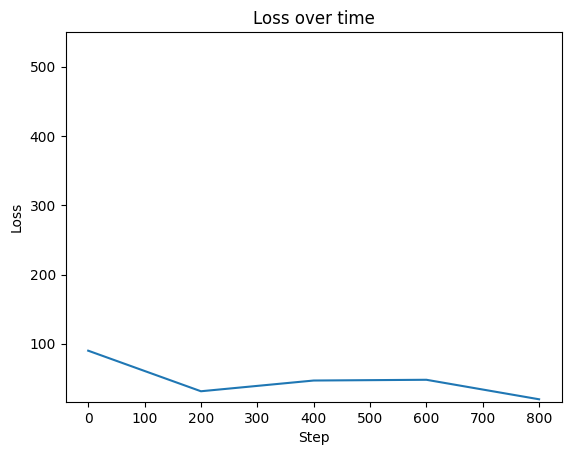

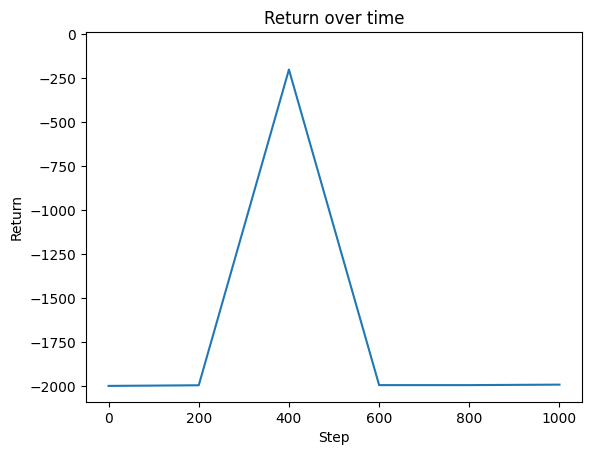

In [10]:
# Visualise the loss using a graph.
X = range(0, len(losses) * log_interval, log_interval)
Y = losses
plt.plot(X, Y)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss over time")
plt.ylim(top=550)
plt.show()

# Visualise the return using a graph.
X = range(0, len(policies) * log_interval, log_interval)
Y = policies
plt.plot(X, Y)
plt.xlabel("Step")
plt.ylabel("Return")
plt.title("Return over time")
plt.ylim(top=10)
plt.show()

## Repeating for Boltzmann Temperature

In [ ]:
""" Hyperparameters """

num_iterations = 10000
ALPHA = 0.0001 
""" Learning rate """
temp = 0.5 
""" Exploration-exploitation tradeoff """

initial_collect_steps = 100
"""Number of times the data collection policy loop is run."""
collect_steps_per_iteration = 1

replay_buffer_max_length = 1000
"""Max length of the replay buffer."""

batch_size = 1
"""Number of experiences used for each training step."""
log_interval = 200
""" The amount of times something is logged in the training loop. """

num_eval_episodes = 50
"""Number of episodes used for the metric."""
eval_interval = 1000
"""Number of times the evaluation loop is used."""
fc_layer_params = fc_layer_params = (6, 128, 64, 6)
"""Parameters for the structure of the neural network."""

In [ ]:
""" Load the environment into TensorFlow. """
env_name = 'Taxi-v3'
env = gym.make(env_name)

ACTIONSIZE = env.action_space.n
OBSERVATIONSIZE = env.observation_space.n
print(ACTIONSIZE, OBSERVATIONSIZE)

env = suite_gym.load(env_name)
train_py_env = eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [ ]:
""" Create the neural network. """
q_net = q_network.QNetwork(train_env.observation_spec(
), train_env.action_spec(), fc_layer_params=fc_layer_params)
q_net.create_variables()
q_net.summary()

In [ ]:
""" Create the agent with the optimiser. """
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=ALPHA)

train_step_counter = tf.Variable(0)
agent = dqn_agent.DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    boltzmann_temperature=temp)

""" print('Observation space:', train_env.observation_spec()) """
""" print('Action space:', train_env.action_spec()) """

""" print('Collect data spec observation:', agent.collect_data_spec.observation) """
""" print('Collect data spec action:', agent.collect_data_spec.action) """

agent.initialize()

In [ ]:
from tf_agents.policies import boltzmann_policy

""" Create policies. """
""" Create policies. """
eval_policy = agent.policy
collect_policy = agent.collect_policy
boltPolicy = boltzmann_policy.BoltzmannPolicy(
    agent.policy, temperature=temp)
    
print(
    f'Policies used are the {eval_policy.name} and the {collect_policy.name}.', )

print('Policy time_step_spec:', eval_policy.time_step_spec)
print('Policy action_spec:', eval_policy.action_spec)

In [ ]:
print(f'True Bolt: average return = {compute_avg_return(eval_env, boltPolicy, num_eval_episodes)}')
print(
    f'Evaluation policy: {eval_policy.name} average return = {compute_avg_return(eval_env, eval_policy, num_eval_episodes)}')
print(
    f'Data Collection Policy: {collect_policy.name} average return = {compute_avg_return(eval_env, collect_policy, num_eval_episodes)}')

In [ ]:
# Import the tf_uniform_replay_buffer module
from tf_agents.replay_buffers import tf_uniform_replay_buffer

# Create a TFUniformReplayBuffer instance
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    max_length=replay_buffer_max_length,
    batch_size=batch_size
)


# Create a ReplayBufferObserver instance
rb_observer = [replay_buffer.add_batch]

""" The driver should use the collect policy, or the training policy for exploration."""
driver = dynamic_step_driver.DynamicStepDriver(
    env=train_env,
    policy=boltPolicy,
    observers=rb_observer,
    num_steps=1
)

""" Initial population of a buffer. """

for _ in range(1000):
    driver.run()

""" Convert the buffer into a dataset. """
dataset = replay_buffer.as_dataset(
    num_steps=2,
    num_parallel_calls=5,
    sample_batch_size=10).prefetch(3)


iterator = iter(dataset)

In [ ]:

"""
For each episode do:
   1. Reset the environment and get the initial state.
   2. While the episode is not done:
       2.1. Agent chooses an action based on the current state.
       2.2. Perform the action in the environment.
       2.3. Receive the reward and the next state from the environment
       2.4. Store the experience (state, action, reward, next state) in the replay buffer
   3. Sample a batch of experiences from the replay buffer.
   4. Use the optimizer to update the agent's network parameters based on the sampled experiences.
5. Repeat steps 4 until the agent is sufficiently trained.
"""
losses = []
policies = [compute_avg_return(train_env, agent.policy, 10)]

agent.train_step_counter.assign(0)




print(f"Agent will output loss every {log_interval} steps.")

agent.collect_policy.update(boltPolicy)

for _ in range(num_iterations):
    experience = next(iterator)
    train_loss = agent.train(experience[0]).loss
    """ if _ % 100 == 0:  # Print every 100 steps
    print(f'Step: {_} \t , Loss: {train_loss}') """
    if _ % log_interval == 0: 
        losses.append(train_loss)
        curr_rtn = compute_avg_return(train_env, driver.policy, 10)
        policies.append(curr_rtn)
        print(f'Step: {_} \t , Loss: {train_loss:.2f} Return: {curr_rtn}')

In [ ]:
# Visualise the loss using a graph.
X = range(0, len(losses) * log_interval, log_interval)
Y = losses
plt.plot(X, Y)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss over time")
plt.ylim(top=550)
plt.show()

# Visualise the return using a graph.
X = range(0, len(policies) * log_interval, log_interval)
Y = policies
plt.plot(X, Y)
plt.xlabel("Step")
plt.ylabel("Return")
plt.title("Return over time")
plt.ylim(top=10)
plt.show()